In [1]:
import os
os.chdir("../")
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.factory.config_factory import cfg, show_configs
from src.factory.data_factory import DataFactory
from src.factory.data_format_factory import DataFormatFactory
from src.factory.transform_factory import TransformFactory
from src.factory.loader_factory import LoaderFactory
from src.base_data import BaseData
from tools.logger import setup_logger
logger = setup_logger("./external/")

In [2]:
cfg.NUM_WORKERS = 1
cfg.DB.PATH = "/media/allen/mass/DB"
cfg.DB.DATA = "ethz coco"
cfg.DB.DATA_FORMAT = "coco_reid"
cfg.DB.TARGET_FORMAT = "yolov3_jde"
cfg.DB.LOADER = "coco_reid"
cfg.DB.USE_TRAIN = True
cfg.DB.USE_TEST = False
cfg.INPUT.SIZE = (576, 320)
cfg.INPUT.TRAIN_BS = 1
cfg.MODEL.STRIDES = [8, 16, 32]
cfg.DB.TRAIN_TRANSFORM = "ResizeKeepAspectRatio Tensorize"
cfg.DB.TEST_TRANSFORM = "Resize Tensorize"
cfg.REID.MSMT_ALL = False
cfg.YOLO.ANCHORS = [6,16, 8,23, 11,32, 16,45,   21,64, 30,90, 43,128, 60,180,   85,255, 120,360, 170,420, 340, 320]


In [3]:
data_names = cfg.DB.DATA.split(" ")
handles = []
indice = []
pids = []
offset = 0
for idx, name in enumerate(data_names[:-1]):
    data = DataFactory.produce(cfg, data_name=name)
    handles.append(data.train['handle'])
    pids.append(data.train['pid'])
    for img_id, img_path in data.train['indice']:
        indice.append((img_id, img_path, idx, offset))
    offset += (max(list(data.train['pid'].values())) + 1)

_data = BaseData()
_data.train['handle'] = handles
_data.train['indice'] = indice
_data.train['pid'] = pids
_data.train['strides'] = cfg.MODEL.STRIDES
_data.train['num_classes'] = offset
cfg.DB.NUM_CLASSES = offset

trans = TransformFactory.produce(cfg, cfg.DB.TRAIN_TRANSFORM)
dataset = DataFormatFactory.produce(cfg, _data.train, trans)

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
2020-04-08 11:23:37,967 21321 coco_reid.py INFO: => COCO TRAIN is loaded
2020-04-08 11:23:37,968 21321 coco_reid.py INFO:   Dataset statistics:
2020-04-08 11:23:37,969 21321 coco_reid.py INFO:   -------------------
2020-04-08 11:23:37,970 21321 coco_reid.py INFO:   subset   | # images
2020-04-08 11:23:37,971 21321 coco_reid.py INFO:   -------------------
2020-04-08 11:23:37,972 21321 coco_reid.py INFO:   train    |    11792
2020-04-08 11:23:37,972 21321 coco_reid.py INFO:   -------------------


In [4]:
batch = dataset[0]

In [3]:
loader = LoaderFactory.produce(cfg)


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
2020-04-08 11:49:16,458 28065 coco_reid.py INFO: => COCO TRAIN is loaded
2020-04-08 11:49:16,459 28065 coco_reid.py INFO:   Dataset statistics:
2020-04-08 11:49:16,459 28065 coco_reid.py INFO:   -------------------
2020-04-08 11:49:16,461 28065 coco_reid.py INFO:   subset   | # images
2020-04-08 11:49:16,461 28065 coco_reid.py INFO:   -------------------
2020-04-08 11:49:16,462 28065 coco_reid.py INFO:   train    |     2056
2020-04-08 11:49:16,463 28065 coco_reid.py INFO:   -------------------


In [4]:
import pycocotools.coco as coco
import json
import os
import os.path as osp
from PIL import Image
from tqdm import tqdm
import numpy as np
import shutil
import cv2

from tools.yolov3_utils import decode_delta_map


In [5]:
batch = next(iter(loader['train']))
batch['bboxes']
bboxes = np.vstack(batch['bboxes'])
bboxes[:, [0,2]] *= 576
bboxes[:, [1,3]] *= 320

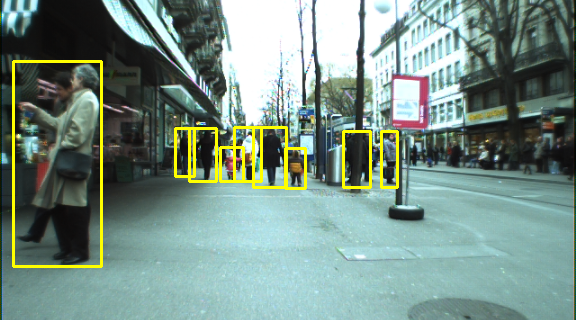

In [10]:
batch = next(iter(loader['train']))
batch['bboxes']
bboxes = np.vstack(batch['bboxes'])
bboxes[:, [0,2]] *= 576
bboxes[:, [1,3]] *= 320
np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
np_img = cv2.resize(np_img, (576,320))
Image.fromarray(np_img)
for b in bboxes:
    x1, y1, x2, y2 = b
    cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
Image.fromarray(np_img)

tensor(13) 72x40
tensor(14) 36x20
tensor(4) 18x10


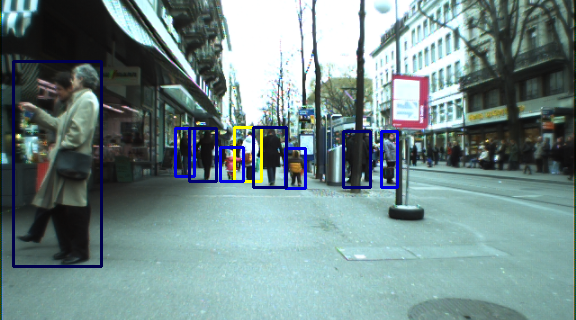

In [11]:
shapes = ['72x40', '36x20', '18x10']
anchors = torch.Tensor(cfg.YOLO.ANCHORS).view(len(cfg.MODEL.STRIDES), -1, 2)
for stage, shape in enumerate(shapes):
    mask = batch[f"yolov3_{shape}_t_conf"] > 0
    t_bbox = batch[f"yolov3_{shape}_t_bbox"]
    print(mask.sum(), shape)
    target_anchors = anchors[stage] / cfg.MODEL.STRIDES[stage]
    p_bbox = decode_delta_map(t_bbox, target_anchors)[mask] * cfg.MODEL.STRIDES[stage]
    p_bbox[:,0] -= p_bbox[:,2] / 2
    p_bbox[:,1] -= p_bbox[:,3] / 2
    for b in p_bbox:
        x1, y1, w, h = b
        cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (0,0,225//(stage+1)), 2)
Image.fromarray(np_img)